<a href="https://colab.research.google.com/github/nargesalavi/CORDIC_in_VHDL/blob/main/QAOA_for_MaxCut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QAOA for MaxCut

In [ ]:
!pip install qiskit

In [4]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In this notebook, we implement the Quantum Approximate Optimization Algorithm (QAOA) to solve MaxCut problem, as proposed in [Farhi et. al.](#https://arxiv.org/abs/1411.4028) 

In [5]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [6]:
from qiskit.aqua.operators.primitive_ops import CircuitOp
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn
from qiskit.aqua.operators.state_fns import CircuitStateFn

from qiskit.aqua.components.optimizers import ADAM

[(0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), (0, 6, 1.0), (0, 7, 1.0), (0, 8, 1.0), (0, 9, 1.0), (0, 10, 1.0), (1, 1, 1.0), (1, 5, 1.0), (1, 6, 1.0), (1, 7, 1.0), (1, 8, 1.0), (2, 4, 1.0), (2, 7, 1.0), (2, 9, 1.0), (3, 3, 1.0), (3, 5, 1.0), (3, 7, 1.0), (3, 10, 1.0), (4, 4, 1.0), (4, 5, 1.0), (4, 7, 1.0), (4, 8, 1.0), (4, 10, 1.0), (4, 11, 1.0), (5, 5, 1.0), (5, 6, 1.0), (5, 8, 1.0), (5, 10, 1.0), (6, 8, 1.0), (6, 9, 1.0), (6, 10, 1.0), (7, 8, 1.0), (7, 10, 1.0), (7, 11, 1.0), (8, 10, 1.0), (8, 11, 1.0), (9, 11, 1.0), (10, 10, 1.0)]


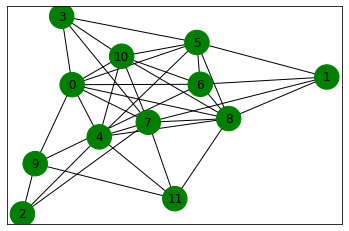

In [7]:
number_of_vertices = 12
vertices = np.arange(0,number_of_vertices,1)
edges = []
for i in range (0,number_of_vertices):
    for j in range(i,number_of_vertices):
        if np.random.random() < 0.5:
            continue
        else:
            edges.append((i,j,1.0))
#edges =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 
print(edges)
G = nx.Graph()
G.add_nodes_from(vertices)
G.add_weighted_edges_from(edges)

# Generate plot of the Graph
colors       = ['g' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [8]:
n_qubits = 4
n_layers = 1
n_wires = n_qubits
edges =[(1, 0), (1, 2), (1,3)]
#edges = [(1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11)]

In [9]:
'''MY CODE'''
# prepare the quantum and classical resisters

def U_initial_state():
  for q in range(n_qubits):
    qaoa_circuit.h(q)

def U_beta(beta):
  for q in range(n_qubits):
    qaoa_circuit.rx(2 * beta, q)

def U_gamma(gamma):
  for edge in edges:
    q1 = edge[0]
    q2 = edge[1]
    qaoa_circuit.cx(q1, q2)
    qaoa_circuit.rz(gamma,q2)
    qaoa_circuit.cx(q1, q2)

def measurement_op(edge):
  c = QuantumCircuit(n_qubits)
  q1 = edge[0]
  q2 = edge[1]
  c.z(q1)
  c.z(q2)

  op = CircuitOp(c)
  return op

def psi_state(params):
  U_initial_state()
  U_beta(init_params[0])
  U_gamma(init_params[1])

In [10]:
'''MY CODE'''

backend = Aer.get_backend('qasm_simulator') 

def calc_expectation(op, psi):
  q_instance = QuantumInstance(backend, shots=1024)

  # define the state to sample
  measurable_expression = StateFn(op, is_measurement=True).compose(psi) 
  # convert to expectation value
  expectation = PauliExpectation().convert(measurable_expression)  

  # get state sampler (you can also pass the backend directly)
  sampler = CircuitSampler(q_instance).convert(expectation) 
  return sampler


In [20]:
import warnings
warnings.filterwarnings('ignore')

import logging, sys
logging.disable(sys.maxsize)

learning_rate = 0.1
#def QAOA_MaxCut_Solver(n_layers=1):
print("\np={:d}".format(n_layers))

# initialize the parameters near zero
init_params = 0.01 * np.random.rand(2, n_layers)
qaoa_circuit = None
epsilon = 0.1
# minimize the negative of the objective function
def objective(params):
    neg_obj = 0
    global qaoa_circuit 
    for edge in edges:
      #print('EDGE:', edge)
      
      qaoa_circuit = QuantumCircuit(n_qubits)
      psi_state(params)
      psi = CircuitStateFn(qaoa_circuit)

      op = measurement_op(edge)

      sampler = calc_expectation(op, psi)

      #print('****************',sampler.eval().real)
      # objective for the MaxCut problem
      neg_obj -= 0.5 * (1 -  sampler.eval().real)

    return neg_obj

# initialize optimizer: Adagrad works well empirically
opt = ADAM()

# optimize parameters in objective
params = init_params
steps = 100

for i in range(steps):
    grads = opt.gradient_num_diff(params,objective,0.05)
    #grad0 = (objective(params + [[epsilon],[0.0]]) - objective(params - [[0.0],[epsilon]]))/(2*epsilon)
    #grad1 = (objective(params - [[0.0],[epsilon]]) - objective(params - [[0.0],[epsilon]]))/(2*epsilon)
    print('Params:',  params, 'Grads', grads)
    #print("VVVVV", grad0, grad1, params)
    params[0] -=learning_rate*grads[0]
    params[1] -=learning_rate*grads[1]
    if (i + 1) % 5 == 0:
        print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))
#a = opt.optimize(2*n_layers,objective)
print(-objective(params),params)
#print(a)
    #return -objective(params),params


p=1
Params: [[0.00730772]
 [0.00707341]] Grads [-0.41015625  0.29296875]
Params: [[ 0.04832335]
 [-0.02222346]] Grads [-0.37109375  0.78125   ]
Params: [[ 0.08543272]
 [-0.10034846]] Grads [-0.99609375 -0.60546875]
Params: [[ 0.1850421 ]
 [-0.03980159]] Grads [-0.5859375  -0.13671875]
Params: [[ 0.24363585]
 [-0.02612971]] Grads [-0.3515625 -0.9765625]
Objective after step     5:  1.4580078
Params: [[0.2787921 ]
 [0.07152654]] Grads [ 0.41015625 -0.8203125 ]
Params: [[0.23777647]
 [0.15355779]] Grads [-0.1171875  -0.25390625]
Params: [[0.24949522]
 [0.17894841]] Grads [ 0.15625    -0.05859375]
Params: [[0.23387022]
 [0.18480779]] Grads [0.87890625 0.60546875]
Params: [[0.1459796 ]
 [0.12426091]] Grads [ 0.56640625 -0.1171875 ]
Objective after step    10:  1.5244141
Params: [[0.08933897]
 [0.13597966]] Grads [-0.078125 -0.234375]
Params: [[0.09715147]
 [0.15941716]] Grads [ 0.1953125  -0.29296875]
Params: [[0.07762022]
 [0.18871404]] Grads [-1.328125  -0.1171875]
Params: [[0.21043272]


In [21]:
'''MY CODE'''
qaoa_circuit = QuantumCircuit(n_qubits)
psi_state(params)


NameError: ignored

In [22]:
import warnings
warnings.filterwarnings('ignore')
backend_sim = Aer.get_backend("qasm_simulator")
shots = 10000
qaoa_circuit = QuantumCircuit(n_qubits)
psi_state(params)
meas = QuantumCircuit(n_qubits, n_qubits)
meas.measure(range(n_qubits), range(n_qubits))
qaoa_circuit.barrier()
qaoa_circuit = qaoa_circuit + meas
qaoa_circuit.draw()


┌───┐┌────┐┌───┐┌────┐┌───┐                                 ░ ┌─┐         
q_0: ┤ H ├┤ RX ├┤ X ├┤ RZ ├┤ X ├─────────────────────────────────░─┤M├─────────
     ├───┤├────┤└─┬─┘└────┘└─┬─┘                                 ░ └╥┘┌─┐      
q_1: ┤ H ├┤ RX ├──■──────────■────■──────────■────■──────────■───░──╫─┤M├──────
     ├───┤├────┤                ┌─┴─┐┌────┐┌─┴─┐  │          │   ░  ║ └╥┘┌─┐   
q_2: ┤ H ├┤ RX ├────────────────┤ X ├┤ RZ ├┤ X ├──┼──────────┼───░──╫──╫─┤M├───
     ├───┤├────┤                └───┘└────┘└───┘┌─┴─┐┌────┐┌─┴─┐ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤ RX ├────────────────────────────────┤ X ├┤ RZ ├┤ X ├─░──╫──╫──╫─┤M├
     └───┘└────┘                                └───┘└────┘└───┘ ░  ║  ║  ║ └╥┘
c: 4/═══════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                    0  1  2  3

In [23]:
job_sim = execute(qaoa_circuit, backend_sim, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qaoa_circuit)
print(counts.most_frequent())

0011


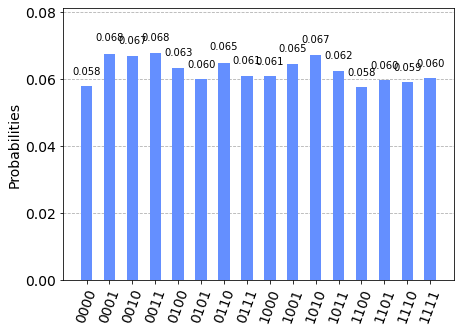

In [24]:
plot_histogram(counts)

In [79]:
print(a)

(array([0.79620962, 0.07192756]), 0.0, 1)


In [ ]:
backend_sim = Aer.get_backend("qasm_simulator")
shots = 10000
qaoa_circuit = QuantumCircuit(n_qubits)
psi_state(params)
meas = QuantumCircuit(n_qubits, n_qubits)
meas.measure(range(n_qubits), range(n_qubits))
qaoa_circuit = qaoa_circuit + meas
job_sim = execute(qaoa_circuit, backend_sim, shots=1024)
result_sim = job_sim.result()

counts = result_sim.get_counts(qaoa_circuit)
plot_histogram(counts)


In [58]:
dev = qml.device("default.qubit", wires=n_wires, shots=1)

In [59]:
n_wires = 3
graph =[(0, 1), (0, 2)]
#graph = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11)]


# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [61]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [47]:
init_params = 0.01 * np.random.rand(2, n_layers)
drawer = qml.draw(circuit)
print(drawer(gammas=init_params[0], betas=init_params[1], edge=(0,1)))

 0: ──H──╭C───────────────╭C─────────────╭C───────────────╭C──RX(0.019)──╭┤ ⟨H0⟩ 
 1: ──H──╰X──RZ(0.00375)──╰X──RX(0.019)──│────────────────│──────────────╰┤ ⟨H0⟩ 
 2: ──H──────────────────────────────────╰X──RZ(0.00375)──╰X──RX(0.019)───┤      
H0 =
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]



In [94]:
v = circuit(gammas=init_params[0], betas=init_params[1], edge=edges[0])
print(v)

-0.24


In [62]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers, shots = 100))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 60
    for i in range(0, n_samples):
        print(i)
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]


p=1
Objective after step     5:  1.1400000
Objective after step    10:  1.4900000
Objective after step    15:  1.4000000
Objective after step    20:  1.6100000
Objective after step    25:  1.4100000
Objective after step    30:  1.6300000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
Optimized (gamma, beta) vectors:
[[-1.06245679]
 [-1.21325215]]
Most frequently sampled bit string is: 0100

p=2
Objective after step     5:  1.4100000
Objective after step    10:  1.2900000
Objective after step    15:  1.5900000
Objective after step    20:  1.4600000
Objective after step    25:  1.6400000
Objective after step    30:  1.2500000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
Optimized (gamma, beta) vectors:
[[-0.52904205 -0.30868313]
 [ 0.1244315  

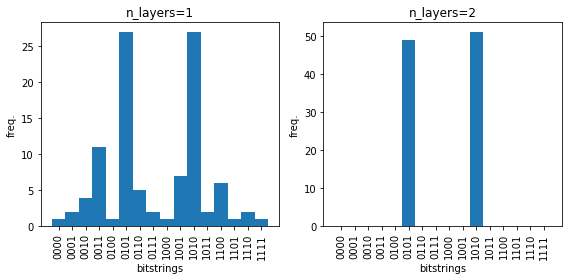

In [ ]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()

In [58]:
dev = qml.device("default.qubit", wires=2)

wires = range(2)
@qml.qnode(dev)
def circuit(x,a):
    qml.RX(x, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    if a:
      return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
    else:
      return [qml.expval(qml.PauliZ(i)) for i in range(2)]

    

In [60]:
drawer = qml.draw(circuit)
angle = np.pi/8
print(drawer(angle,True))

 0: ──RX(0.393)──╭C──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──H──────────╰X──╰┤ ⟨Z ⊗ Z⟩ 



In [61]:
print(drawer(angle,False))

 0: ──RX(0.393)──╭C──┤ ⟨Z⟩ 
 1: ──H──────────╰X──┤ ⟨Z⟩ 



In [62]:
circuit(angle,True)

tensor(0., requires_grad=True)

In [63]:
circuit(angle, False)

tensor([0.92387953, 0.        ], requires_grad=True)

2


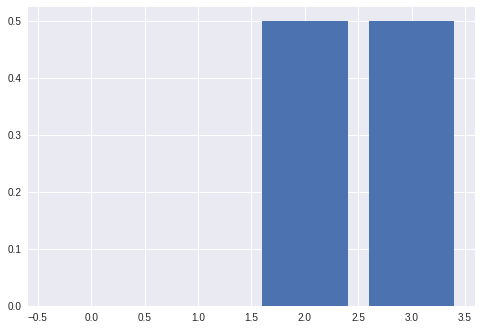

In [52]:
@qml.qnode(dev)
def probability_circuit(angle):
    qml.RX(angle, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.probs(wires=wires)

print(len(wires))
probs = probability_circuit(angle)
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [41]:
wires

range(0, 2)